In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch [1/25], Loss: 14.8172, Accuracy: 47.27%


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch [2/25], Loss: 14.5971, Accuracy: 46.06%


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Epoch [3/25], Loss: 14.5249, Accuracy: 58.18%


100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch [4/25], Loss: 14.4038, Accuracy: 54.55%


100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Epoch [5/25], Loss: 14.0781, Accuracy: 63.03%


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch [6/25], Loss: 12.5965, Accuracy: 67.88%


100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


Epoch [7/25], Loss: 10.2559, Accuracy: 78.18%


100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Epoch [8/25], Loss: 7.4371, Accuracy: 87.27%


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Epoch [9/25], Loss: 11.6692, Accuracy: 76.97%


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch [10/25], Loss: 8.9770, Accuracy: 86.06%


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Epoch [11/25], Loss: 6.0298, Accuracy: 89.09%


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Epoch [12/25], Loss: 5.6637, Accuracy: 91.52%


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch [13/25], Loss: 5.3375, Accuracy: 93.33%


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch [14/25], Loss: 4.8088, Accuracy: 92.73%


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch [15/25], Loss: 3.3613, Accuracy: 94.55%


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Epoch [16/25], Loss: 2.2869, Accuracy: 96.36%


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch [17/25], Loss: 3.8246, Accuracy: 93.33%


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch [18/25], Loss: 1.7376, Accuracy: 98.18%


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Epoch [19/25], Loss: 1.4591, Accuracy: 98.18%


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Epoch [20/25], Loss: 0.7477, Accuracy: 98.79%


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch [21/25], Loss: 0.4486, Accuracy: 99.39%


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Epoch [22/25], Loss: 1.1292, Accuracy: 97.58%


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Epoch [23/25], Loss: 0.2859, Accuracy: 100.00%


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch [24/25], Loss: 0.0764, Accuracy: 100.00%


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch [25/25], Loss: 0.8895, Accuracy: 98.79%
Model saved as 'att_lstm_classifier.pth'
mAP score (AP for class 'waste_absent'): 0.9826
mAP score (AP for class 'waste_present'): 0.9790


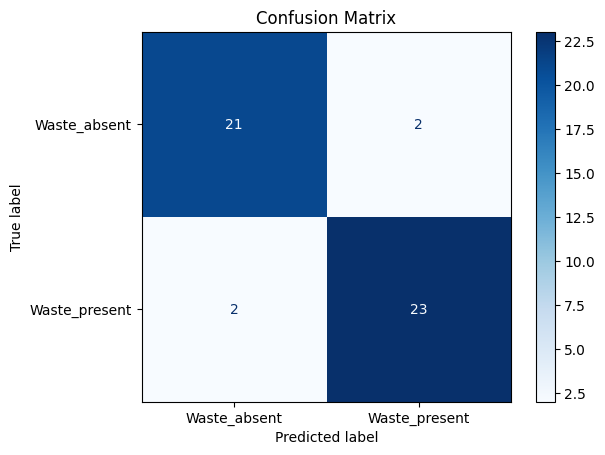

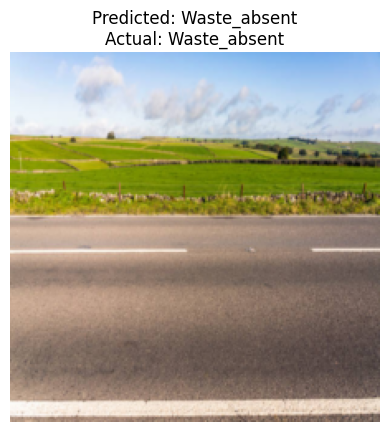

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# --- Attention + LSTM Model ---
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        attn_weights = torch.softmax(self.attn(lstm_output), dim=1)
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context

class AttLSTMClassifier(nn.Module):
    def __init__(self, num_classes=2, hidden_dim=128):
        super(AttLSTMClassifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.lstm_input_size = 56 * 56
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.cnn(x)
        x = x.view(batch_size, 32, -1)
        lstm_out, _ = self.lstm(x)
        context = self.attention(lstm_out)
        out = self.fc(context)
        return out

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load and split dataset from your folders
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/review two data", transform=transform)  # waste_present/ and waste_absent/

# Train/Val/Test Split (70:10:20)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

# --- Model Setup ---
model = AttLSTMClassifier(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 25

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

# --- Save Model ---
torch.save(model.state_dict(), "att_lstm_classifier.pth")
print("Model saved as 'att_lstm_classifier.pth'")

# --- mAP Evaluation for both classes ---
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # shape: [batch_size, 2]
        all_probs.extend(probs.cpu().numpy())  # collect probabilities for both classes
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)     # shape: [num_samples, 2]
all_labels = np.array(all_labels)   # shape: [num_samples]

# Compute Average Precision for both classes
ap_waste_absent = average_precision_score(all_labels == 0, all_probs[:, 0])
ap_waste_present = average_precision_score(all_labels == 1, all_probs[:, 1])

print(f"mAP score (AP for class 'waste_absent'): {ap_waste_absent:.4f}")
print(f"mAP score (AP for class 'waste_present'): {ap_waste_present:.4f}")


# --- Confusion Matrix ---
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes  # ['waste_absent', 'waste_present']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Sample Output ---
index = random.randint(0, len(test_set) - 1)
sample_image, sample_label = test_set[index]
image_tensor = sample_image.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, pred_class = torch.max(output, 1)

img_np = sample_image.permute(1, 2, 0).cpu().numpy()
plt.imshow(img_np)
plt.title(f"Predicted: {class_names[pred_class.item()]}\nActual: {class_names[sample_label]}")
plt.axis("off")
plt.show()


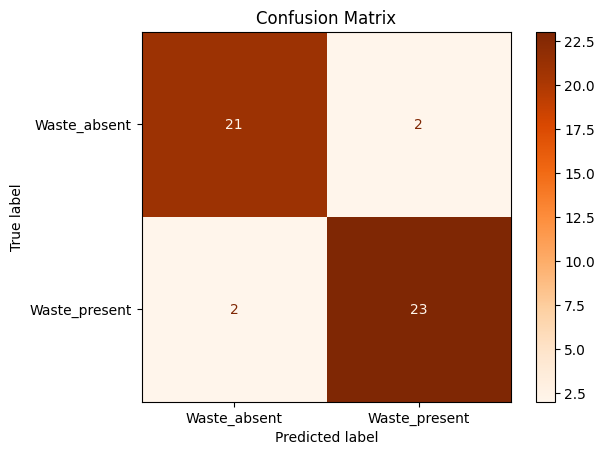

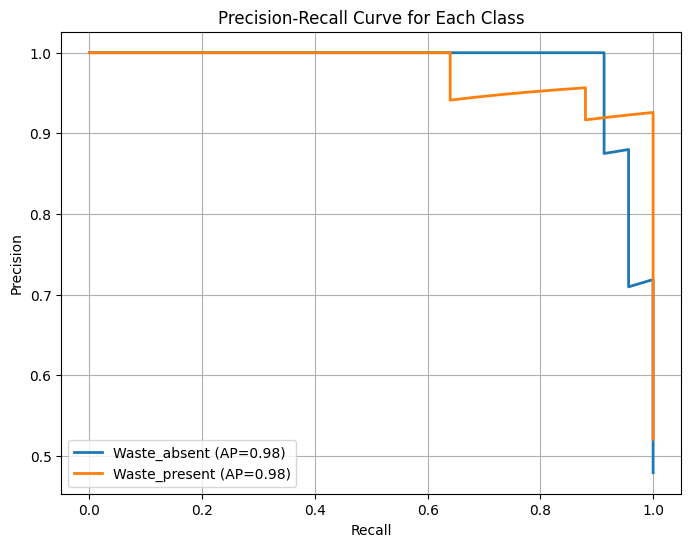

In [10]:
from sklearn.metrics import precision_recall_curve, auc

# --- Recalculate probs and labels if not already in memory ---
# You can skip this if you've already run the mAP cell just before
model.eval()
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Oranges, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Precision-Recall Curve ---
plt.figure(figsize=(8, 6))

for i, class_name in enumerate(class_names):
    binary_labels = (all_labels == i).astype(int)
    precision, recall, _ = precision_recall_curve(binary_labels, all_probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f"{class_name} (AP={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.grid(True)
plt.show()


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch [1/25] Train Loss: 0.0098 | Train Acc: 100.00% | Val Loss: 0.3937 | Val Acc: 86.96%


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Epoch [2/25] Train Loss: 0.0046 | Train Acc: 100.00% | Val Loss: 0.3815 | Val Acc: 91.30%


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch [3/25] Train Loss: 0.0016 | Train Acc: 100.00% | Val Loss: 0.6536 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


Epoch [4/25] Train Loss: 0.0011 | Train Acc: 100.00% | Val Loss: 0.7086 | Val Acc: 86.96%


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Epoch [5/25] Train Loss: 0.0008 | Train Acc: 100.00% | Val Loss: 0.7405 | Val Acc: 86.96%


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Epoch [6/25] Train Loss: 0.0007 | Train Acc: 100.00% | Val Loss: 0.7584 | Val Acc: 86.96%


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch [7/25] Train Loss: 0.0006 | Train Acc: 100.00% | Val Loss: 0.7771 | Val Acc: 86.96%


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Epoch [8/25] Train Loss: 0.0005 | Train Acc: 100.00% | Val Loss: 0.7985 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch [9/25] Train Loss: 0.0004 | Train Acc: 100.00% | Val Loss: 0.8135 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch [10/25] Train Loss: 0.0004 | Train Acc: 100.00% | Val Loss: 0.8317 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch [11/25] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.8479 | Val Acc: 86.96%


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch [12/25] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.8614 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch [13/25] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.8744 | Val Acc: 86.96%


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Epoch [14/25] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.8851 | Val Acc: 86.96%


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch [15/25] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.8995 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch [16/25] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.9093 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch [17/25] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.9191 | Val Acc: 86.96%


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Epoch [18/25] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.9281 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Epoch [19/25] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.9393 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch [20/25] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.9486 | Val Acc: 86.96%


100%|██████████| 21/21 [00:19<00:00,  1.06it/s]


Epoch [21/25] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.9556 | Val Acc: 86.96%


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Epoch [22/25] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.9632 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch [23/25] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.9737 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch [24/25] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.9784 | Val Acc: 86.96%


100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch [25/25] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.9842 | Val Acc: 86.96%


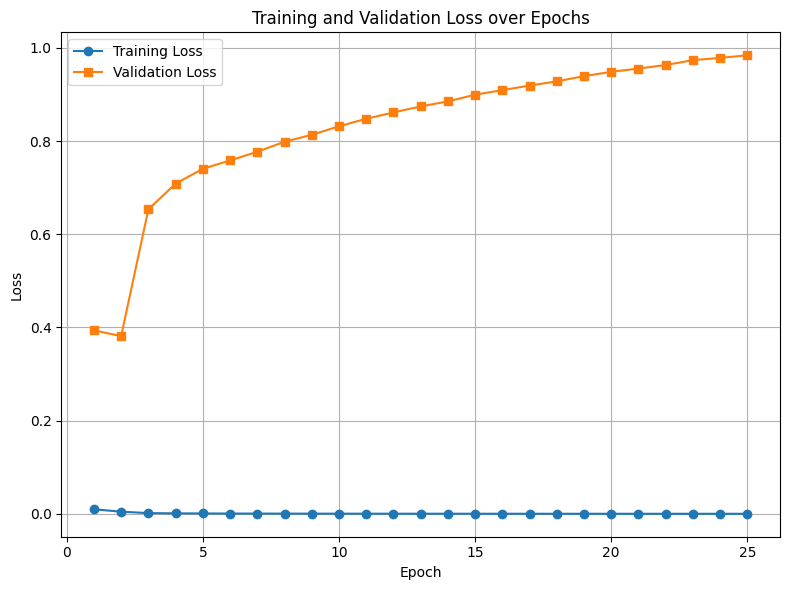

In [12]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

# --- Plot Training vs. Validation Loss ---
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
